In [1]:
%matplotlib inline
from cox import readers
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set()

In [3]:
r = readers.CollectionReader('agents')

100%|██████████| 120/120 [00:15<00:00,  7.98it/s]


In [4]:
metadata = r.df('metadata')
opt = r.df('optimization')
nadv = r.df('normalized_advantage')
constraints = r.df('paper_constraints_train')
constraints_heldout = r.df('paper_constraints_heldout')

In [8]:
code_level_opts = {
      'kl_penalty_coeff': [3, 0.0],
      'kl_penalty_direction': ['new_to_old', 'old_to_new'],
      'clip_advantages': [3, 5, 1e8],
      #'norm_rewards': ['none', 'returns'],
      #'anneal_lr': [False, True],
      #'value_clipping': [False, True],
      #'initialization': ['xavier', 'orthogonal']
}

NUM_BINS = 20

In [6]:
key_metadata = metadata[['exp_id', 'game', 'clip_eps', 'kl_penalty_coeff', 'kl_penalty_direction',
                         'clip_advantages', 'norm_rewards', 'anneal_lr']]

# Plot max rewards

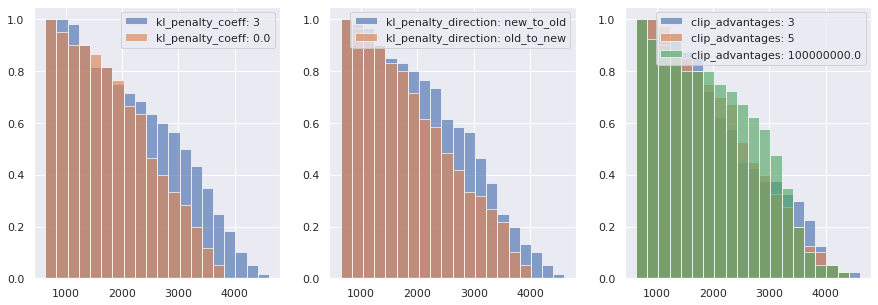

In [11]:
max_rewards = opt.groupby('exp_id').max()

# Histogram setup
_, bin_edges = np.histogram(max_rewards['mean_reward'].tolist(), NUM_BINS)
bin_locs = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_ws = (bin_edges[1] - bin_edges[0])

# Plot setup
kwargs = {'width': bin_ws, 'alpha': 0.65}
fig, ax = plt.subplots(1, 3, figsize=(15,5))

for i, cl_opt in enumerate(code_level_opts):
    for b in code_level_opts[cl_opt]:
        exp_ids = set(metadata[metadata[cl_opt] == b]['exp_id'].tolist())
        filt = max_rewards[max_rewards.index.isin(exp_ids)]
        hist, _ = np.histogram(filt['mean_reward'].tolist(), bin_edges)
        hist = np.flip(np.cumsum(np.flip(hist))) / np.sum(hist)
        ax.flatten()[i].bar(bin_locs, hist, label=f"{cl_opt}: {b}", **kwargs)
    ax.flatten()[i].legend()
plt.show()

In [12]:
for i, cl_opt in enumerate(code_level_opts):
    print(cl_opt)
    for b in reversed(code_level_opts[cl_opt]):
        exp_ids = set(metadata[(metadata[cl_opt] == b)]['exp_id'].tolist())
        filt = max_rewards[max_rewards.index.isin(exp_ids)]
        print(b, filt['mean_reward'].count(), filt['mean_reward'].mean(), filt['mean_reward'].var())

kl_penalty_coeff
0.0 60 2393.37984979007 679043.3651616445
3 60 2794.9984613668416 1070430.4488043822
kl_penalty_direction
old_to_new 60 2429.3532059826016 830280.3942328522
new_to_old 60 2759.025105174309 945946.2746729305
clip_advantages
100000000.0 40 2653.152665906903 961110.1921574061
5 40 2545.7972152455463 852189.8204136359
3 40 2583.6175855829156 951332.5760873398


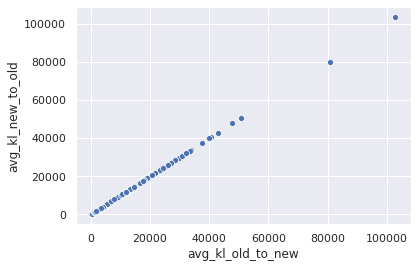

In [13]:
sns.scatterplot(constraints.avg_kl_old_to_new, constraints.avg_kl_new_to_old)

In [15]:
from scipy.stats.stats import pearsonr   
pearsonr(constraints.avg_kl_old_to_new.dropna(), constraints.avg_kl_new_to_old.dropna())

(0.9999829359738094, 0.0)

# Advantage Distribution

In [17]:
nadv.head(2)

,opt_step,skewness,kurtosis,max,min,exp_id
0,0,0.219948,3.428624,3.303992,-4.785997,625d642c-697c-4ad8-ad1d-180a651cc7b2
1,10,-0.488569,4.231401,3.143982,-4.296059,625d642c-697c-4ad8-ad1d-180a651cc7b2


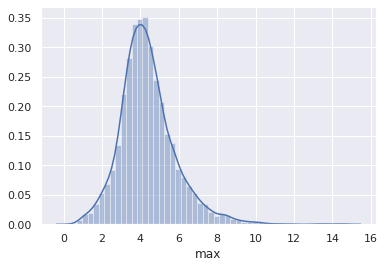

In [19]:
sns.distplot(nadv['max'])

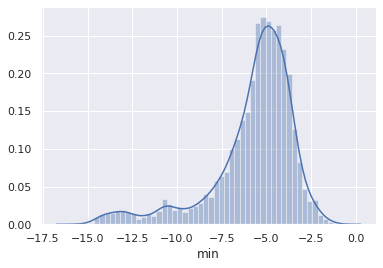

In [20]:
sns.distplot(nadv['min'])

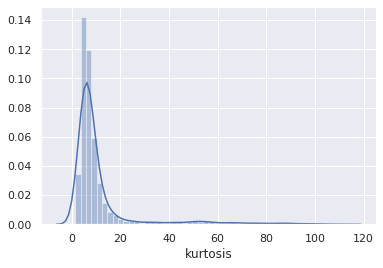

In [21]:
sns.distplot(nadv['kurtosis'])

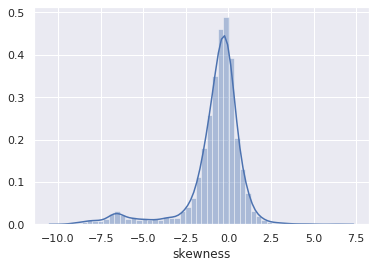

In [22]:
sns.distplot(nadv['skewness'])

# Explaining Trust Region with Adv Distribution

In [23]:
constraints.head(2)

,avg_kl_old_to_new,avg_kl_new_to_old,max_ratio,opt_step,exp_id
0,0.010759,0.010689,1.618355,0,625d642c-697c-4ad8-ad1d-180a651cc7b2
1,0.012494,0.012404,1.931678,10,625d642c-697c-4ad8-ad1d-180a651cc7b2


In [25]:
opt['opt_step'] = opt.index
nadv['opt_step'] = (nadv.index % 50) * 10

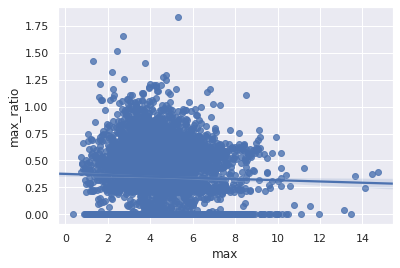

In [29]:
sns.regplot(x=nadv['max'],
            y=np.log(np.maximum(constraints['max_ratio'], 1)))

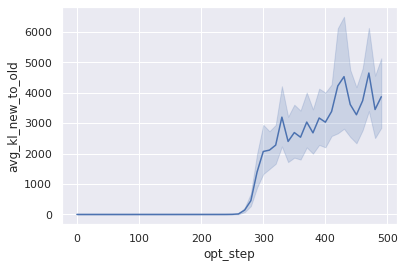

In [30]:
sns.lineplot(x=constraints['opt_step'], y=constraints['avg_kl_new_to_old'])

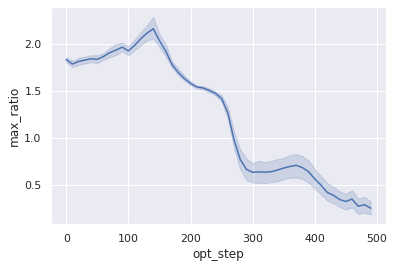

In [31]:
sns.lineplot(x=constraints['opt_step'], y=constraints['max_ratio'])

# Aggregate performance (max over learning rates, avg over trials)

In [35]:
ks = list(code_level_opts.keys())
grouped_1 = max_rewards.merge(metadata, on='exp_id').groupby(ks).mean().reset_index().set_index(ks)
grouped_1

mean_reward  \
kl_penalty_coeff kl_penalty_direction clip_advantages                
0.0              new_to_old           3.0              2490.399947   
                                      5.0              2614.037493   
                                      100000000.0      2723.891328   
                 old_to_new           3.0              2014.203398   
                                      5.0              2415.318418   
                                      100000000.0      2102.428515   
3.0              new_to_old           3.0              3124.646482   
                                      5.0              2590.458007   
                                      100000000.0      3010.717374   
                 old_to_new           3.0              2705.220516   
                                      5.0              2563.374943   
                                      100000000.0      2775.573446   

                                                       final_value_loss  \
kl_penalty_coeff kl_penalty_direction clip_advantages                     
0.0              new_to_old           3.0                      0.413574   
                                      5.0                      0.331576   
                                      100000000.0              0.356599   
                 old_to_new           3.0                      0.244671   
                                      5.0                      0.465637   
                                      100000000.0              0.483652   
3.0              new_to_old           3.0                      0.374387   
                                      5.0                      0.355801   
                                      100000000.0              0.234449   
                 old_to_new           3.0                      0.475829   
                                      5.0                      0.466830   
                                      100000000.0              0.436148   

                                                       mean_std  \
kl_penalty_coeff kl_penalty_direction clip_advantages             
0.0              new_to_old           3.0              0.991001   
                                      5.0              0.993113   
                                      100000000.0      0.990915   
                 old_to_new           3.0              0.993633   
                                      5.0              0.992023   
                                      100000000.0      0.991049   
3.0              new_to_old           3.0              1.001743   
                                      5.0              0.998922   
                                      100000000.0      0.996261   
                 old_to_new           3.0              0.994739   
                                      5.0              0.994840   
                                      100000000.0      0.997660   

                                                       num_minibatches  \
kl_penalty_coeff kl_penalty_direction clip_advantages                    
0.0              new_to_old           3.0                           32   
                                      5.0                           32   
                                      100000000.0                   32   
                 old_to_new           3.0                           32   
                                      5.0                           32   
                                      100000000.0                   32   
3.0              new_to_old           3.0                           32   
                                      5.0                           32   
                                      100000000.0                   32   
                 old_to_new           3.0                           32   
                                      5.0                           32   
                                      100000000.0                   32   

                                               